In [2]:
import numpy as np
import cv2
import pickle
import glob
import color
import matplotlib.pyplot as plt
import gradient as gd
import calibration as cal
import unwarp as uw
import lines as ln
from ipywidgets import interact, interactive, fixed
from IPython.display import HTML
from moviepy.editor import VideoFileClip
%matplotlib inline

Text(0.5, 1.0, 'Undistorted Image')

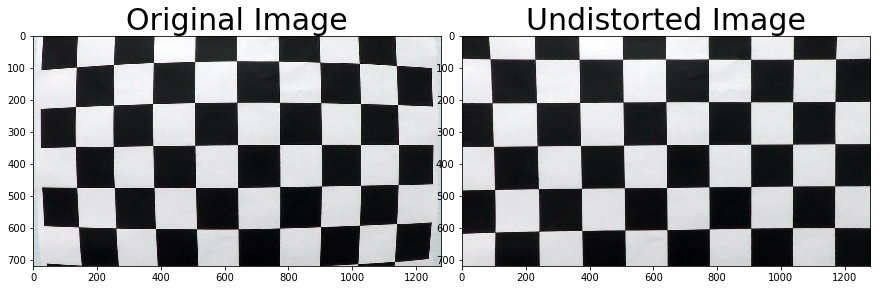

In [3]:
mtx, dist=cal.calibration('camera_cal')
img = cv2.imread('camera_cal/calibration1.jpg')
dst = cv2.undistort(img, mtx, dist, None, mtx) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Text(0.5, 1.0, 'Undistorted Image')

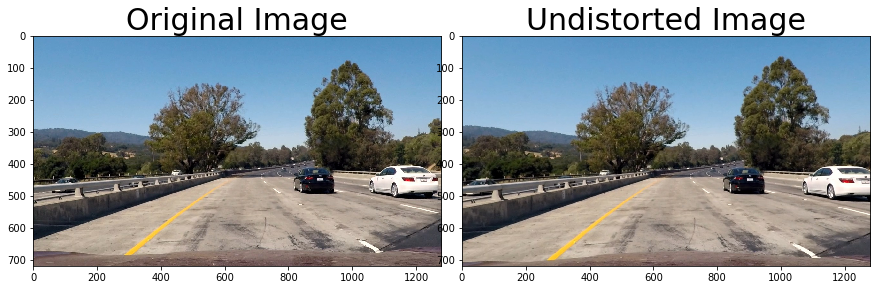

In [4]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

dst = cv2.undistort(img, mtx, dist, None, mtx)
 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

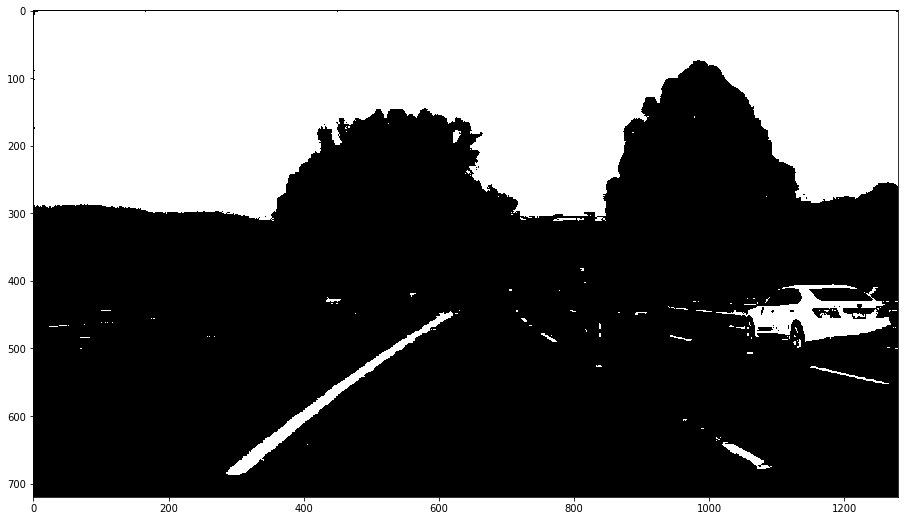

In [5]:
img = cv2.imread('test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# HLS L-channel Threshold (using default parameters)
img_l = color.hls_lthresh(img)
    
# HLS S-channel Threshold (using default parameters)
img_s = color.hls_sthresh(img)

# RGB R-channel Threshold (using default parameters)
img_r = color.rgb_rthresh(img)
    
# Combine HLS and Lab B channel thresholds
combined = np.zeros_like(img_l)
combined[(img_r == 1)|((img_l == 1)&(img_s == 1))]=1
plt.imshow(combined, cmap='gray')
fig = plt.gcf()
fig.set_size_inches(15.5, 10.5)

Text(0.5, 1.0, 'Unwarped Image')

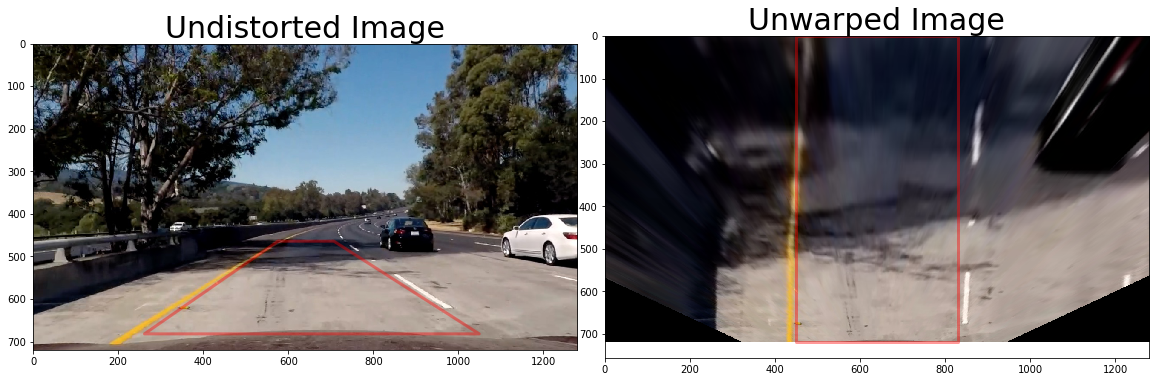

In [29]:
# define source and destination points for transform
rect_src = np.float32([(576,464),
                  (707,464), 
                  (262,682), 
                  (1049,682)])
rect_dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

img_unwarp, M, Minv = uw.unwarp(dst, rect_src, rect_dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(dst)
x = [rect_src[0][0],rect_src[2][0],rect_src[3][0],rect_src[1][0],rect_src[0][0]]
y = [rect_src[0][1],rect_src[2][1],rect_src[3][1],rect_src[1][1],rect_src[0][1]]
ax1.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(img_unwarp)
x = [rect_dst[0][0],rect_dst[2][0],rect_dst[3][0],rect_dst[1][0],rect_dst[0][0]]
y = [rect_dst[0][1],rect_dst[2][1],rect_dst[3][1],rect_dst[1][1],rect_dst[0][1]]
ax2.plot(x, y, color='#ff0000', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax2.set_title('Unwarped Image', fontsize=30)

In [7]:
img = cv2.imread('test_images/test5.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img, mtx, dist, None, mtx)
img_unwarp, M, Minv = uw.unwarp(dst, rect_src, rect_dst)

In [8]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# Import is rgp picture

def pipeline(img):
    
    # Undistort
    img_undis = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Perspective Transform
    img_unwarp, M, Minv = uw.unwarp(img_undis, rect_src, rect_dst)

    # Sobel Absolute (using default parameters)
    #img_sobelx = gd.abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = gd.mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    #img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_l = color.hls_lthresh(img_unwarp)
    
     # HLS S-channel Threshold (using default parameters)
    img_s = color.hls_sthresh(img_unwarp)

    # RGB R-channel Threshold (using default parameters)
    img_r = color.rgb_rthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_l)
    combined[(img_r == 1)|((img_l == 1)&(img_s == 1))]=1
    
    return combined, Minv

In [9]:
#Initialization
pre_right_fit=[];
pre_left_fit=[];
reinitial=True;

In [25]:
def drawMark(img,draw_pts,left_curverad,right_curverad,bias):
    color_warp = np.zeros_like(img).astype(np.uint8)
    #color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
         
    cv2.fillPoly(color_warp, np.int_([draw_pts]), (0,255, 0))
   
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    curverad = (left_curverad+right_curverad)/2
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    text1 = 'Radius of Curvature: ' + '{:04.2f}'.format(curverad) + 'm'
    textc = 'Vehicle is ' + '{:04.2f}'.format(bias) + 'm' + ' left of center'
    cv2.putText(result, text1, (100,60), cv2.FONT_HERSHEY_DUPLEX, 2, [255,255,255], 1, cv2.LINE_AA)
    cv2.putText(result, textc, (100,120), cv2.FONT_HERSHEY_DUPLEX, 2, [255,255,255], 1, cv2.LINE_AA)
    return result

In [11]:
def sanity(left_curverad,right_curverad):
    if left_curverad<100:
        return True
    if right_curverad<100:
        return True
    if abs(left_curverad-right_curverad)>10000:
        return True
    return False

In [12]:
def process_image(img):
    global pre_left_fit
    global pre_right_fit
    global reinitial
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    left_fit,right_fit,left_curverad,right_curverad,bias,draw_pts = ln.findlines(img_bin, pre_left_fit, pre_right_fit, reinitial)
    pre_left_fit = left_fit
    pre_right_fit = right_fit
    reinitial = sanity(left_curverad,right_curverad)
    return drawMark(img,draw_pts,left_curverad,right_curverad,bias)

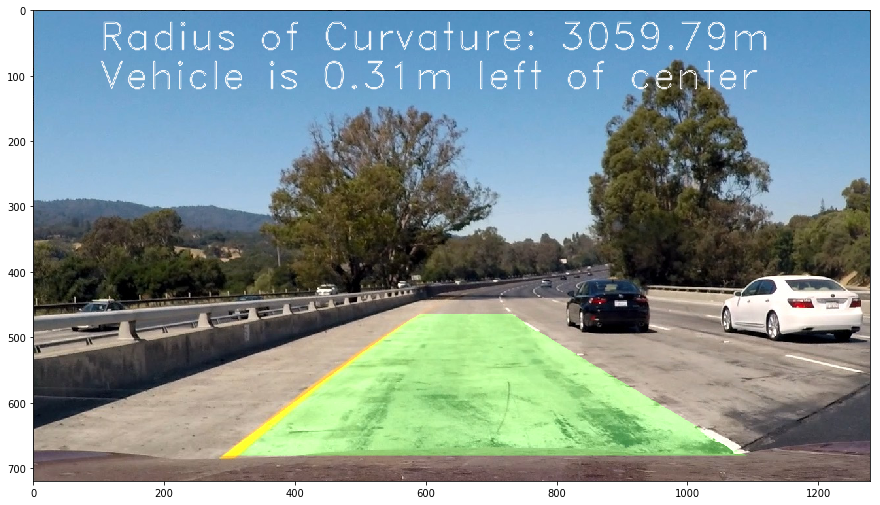

In [26]:
img1 = cv2.imread('test_images/test1.jpg')
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img2 = process_image(img1)
plt.imshow(img2)
fig = plt.gcf()
fig.set_size_inches(15, 10)

In [27]:
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [01:40<00:00, 12.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 1min 41s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))